In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from cuml import DBSCAN as cumlDBSCAN
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
!python --version

Python 3.7.10


In [5]:
!pwd

/rapids/notebooks/host


In [6]:
data_dir='/rapids/notebooks/host/QA_attentions_pickled'

In [7]:
df = cudf.read_csv(os.path.join(data_dir,'representation_df.csv'))

In [82]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 288000 entries, 0 to 287999
Columns: 2049 entries, Unnamed: 0 to 2047
dtypes: float64(2048), int64(1)
memory usage: 4.4 GB


In [8]:
## From running HDBSCAN on CPU on 14400 samples
# start_time = time.time()
# clusterer2 = hdbscan.HDBSCAN(
#     metric="manhattan",
#     min_cluster_size=40,
#     min_samples = 20,
#     core_dist_n_jobs=16)
# clusterer2.fit(df_b)
# print("--- %s seconds ---" % (time.time() - start_time))
##--- 729.1382730007172 seconds ---

In [11]:
df_small = df[0:14400]

In [14]:
df_small.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Columns: 2049 entries, Unnamed: 0 to 2047
dtypes: float64(2048), int64(1)
memory usage: 225.1 MB


In [7]:
cuml_dbscan = cumlDBSCAN( eps = 0.000001,
                          metric='euclidean',
                          min_samples = 5)

In [78]:
start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(df_small)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.435322523117065 seconds ---


CuML DBScan, albeit with a different parameterization, ran nearly 200x faster than CPU

Here we use Nearest Neighbors in our subset to find an optimal Epsilon for DBSCAN

In [29]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(sm)
distances, idx = nn.kneighbors(sm)
distances = distances.values


<Figure size 720x360 with 0 Axes>

In [36]:
distances = cupy.asnumpy(distances)

In [38]:
distances[:10]

array([[0.        , 0.29186642, 0.77420497, 0.8226489 , 0.82618546],
       [0.00138107, 0.34081823, 0.7350986 , 0.8109363 , 0.81589735],
       [0.00352105, 0.24164744, 0.7432032 , 0.7448522 , 0.74507016],
       [0.00195312, 0.1845393 , 0.6967942 , 0.7010052 , 0.7132925 ],
       [0.00195312, 0.3866059 , 0.7982116 , 0.8248956 , 0.8423875 ],
       [0.        , 0.4345396 , 0.7860506 , 0.8078775 , 0.8130605 ],
       [0.        , 0.38028616, 0.8245126 , 0.84708846, 0.8518267 ],
       [0.00195312, 0.45699108, 0.79223686, 0.8058223 , 0.8072274 ],
       [0.00138107, 0.19984964, 0.7352251 , 0.74168104, 0.7434059 ],
       [0.        , 0.50276184, 0.82692355, 0.8535136 , 0.86132836]],
      dtype=float32)

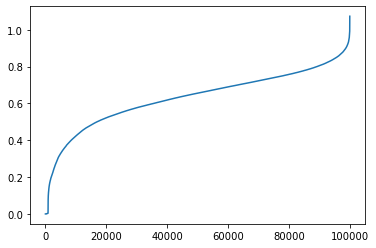

In [39]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [42]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.75,
                          metric='euclidean',
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(sm)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 255.34441256523132 seconds ---
Estimated number of clusters: 55
Estimated number of noise points: 36019
CPU times: user 4min 15s, sys: 256 ms, total: 4min 15s
Wall time: 4min 15s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

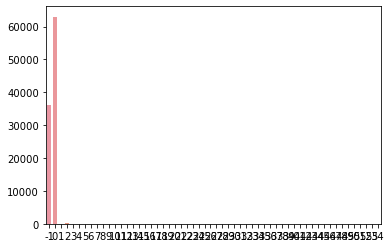

In [44]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [45]:
rating_count

 0     62977
-1     36019
 2       352
 11       50
 5        35
 1        22
 3        22
 35       21
 18       19
 23       16
 20       16
 21       15
 22       14
 19       14
 24       13
 39       12
 41       12
 33       12
 38       12
 42       12
 10       12
 4        12
 27       11
 44       11
 25       11
 28       11
 26       10
 37       10
 54       10
 51       10
 50       10
 49       10
 47       10
 45       10
 43       10
 17       10
 12       10
 8        10
 36       10
 15       10
 13       10
 30       10
 34       10
 31       10
 9         9
 32        9
 40        9
 14        8
 7         8
 29        8
 6         7
 16        7
 46        6
 48        6
 52        6
 53        4
Name: 0, dtype: int64

In [7]:
med = df[:400000]

In [8]:
med = med.iloc[:,1:]

In [9]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.75,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(med)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 4578.115650892258 seconds ---
Estimated number of clusters: 69
Estimated number of noise points: 105521
CPU times: user 1h 16min 21s, sys: 2.47 s, total: 1h 16min 23s
Wall time: 1h 16min 18s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

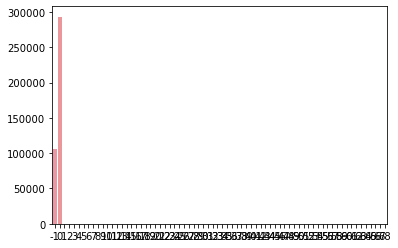

In [13]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
label_count = df_labels[0].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)

In [14]:
rating_count

 0     293241
-1     105521
 2        198
 4         46
 10        42
        ...  
 67         8
 9          7
 56         7
 43         7
 57         5
Name: 0, Length: 70, dtype: int64

In [15]:
rating_count[:20]

 0     293241
-1     105521
 2        198
 4         46
 10        42
 1         40
 6         40
 60        37
 26        33
 25        33
 51        30
 15        30
 5         28
 14        26
 46        24
 7         23
 13        21
 45        21
 8         19
 53        19
Name: 0, dtype: int64